<a href="https://colab.research.google.com/github/WilliamUWE1/AI_Submission/blob/main/Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Mount drive, imports
from google.colab import drive
drive.mount('/content/gdrive')

!unzip '/content/gdrive/MyDrive/Coursework_dataset.zip' > /dev/null

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

Mounted at /content/gdrive


In [ ]:
## Set Variables

data_dir = 'Coursework_dataset'

n_epochs = 10
n_epochs2 = 15
n_epochs3 = 30
n_epochs4 = 50

batch_size = 8

image_res = 112
image_res2 = 164
image_res3 = 256

numberOfClasses = 5

lr1 = 0.003
lr2 = 0.03
lr3 = 0.1

transform = transforms.Compose([transforms.Resize(image_res), 
                                transforms.CenterCrop(image_res),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(), 
                                transforms.Normalize([0.5, 0.5, 0.5],
                                                     [0.5, 0.5, 0.5])])

transform_2 = transforms.Compose([transforms.Resize(image_res),
                                transforms.CenterCrop(image_res),
                                transforms.RandomRotation(5),
                                transforms.ToTensor(), 
                                transforms.Normalize([0.5, 0.5, 0.5],
                                                     [0.5, 0.5, 0.5])])

transform_3 = transforms.Compose([transforms.Resize(image_res),
                                transforms.CenterCrop(image_res),
                                transforms.GrayScale(),
                                transforms.ToTensor(), 
                                transforms.Normalize([0.5, 0.5, 0.5],
                                                     [0.5, 0.5, 0.5])])

train_data = datasets.ImageFolder(data_dir + '/train', transform=transform)
val_data = datasets.ImageFolder(data_dir + '/validate', transform=transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)


train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

#MLP

In [ ]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [ ]:
input_size = image_res * image_res * 3
                                                                   
from torch import nn, optim
import torch.nn.functional as F


class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        hidden_1 = 2048
        hidden_2 = 1024
        hidden_3 = 512
        
        self.fc1 = nn.Linear(input_size, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, hidden_3)
        self.fc4 = nn.Linear(hidden_3, numberOfClasses) 

        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):

        x = x.view(-1, input_size)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1) 
        return x

model = Classifier()
print(model)

Classifier(
  (fc1): Linear(in_features=37632, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=5, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [ ]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=lr1)

In [ ]:

valid_loss_min = np.Inf

train_losses, val_losses = [], []

for epoch in range(n_epochs):

    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() 
    for data, target in train_loader:

        optimizer.zero_grad()

        output = model(data)
 
        loss = criterion(output, target)

        loss.backward()

        optimizer.step()

        train_loss += loss.item()*data.size(0)
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in val_loader:

        output = model(data)

        loss = criterion(output, target)

        valid_loss += loss.item()*data.size(0)
        
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)

    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'CW_MLP_model.pt')
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/CW_MLP_model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 13271.723676 	Validation Loss: 4461.799630
Validation loss decreased (inf --> 4461.799630).  Saving model ...
Epoch: 2 	Training Loss: 3835.998186 	Validation Loss: 24.588249
Validation loss decreased (4461.799630 --> 24.588249).  Saving model ...
Epoch: 3 	Training Loss: 298.473482 	Validation Loss: 6.071104
Validation loss decreased (24.588249 --> 6.071104).  Saving model ...
Epoch: 4 	Training Loss: 196.489774 	Validation Loss: 1.590789
Validation loss decreased (6.071104 --> 1.590789).  Saving model ...
Epoch: 5 	Training Loss: 169.663271 	Validation Loss: 1.593100
Epoch: 6 	Training Loss: 2686.303628 	Validation Loss: 1.595685
Epoch: 7 	Training Loss: 1148.680988 	Validation Loss: 1.590016
Validation loss decreased (1.590789 --> 1.590016).  Saving model ...
Epoch: 8 	Training Loss: 134.882309 	Validation Loss: 1.591078
Epoch: 9 	Training Loss: 1.595151 	Validation Loss: 1.595031
Epoch: 10 	Training Loss: 1.617386 	Validation Loss: 1.593143
Epoch: 11 	Train

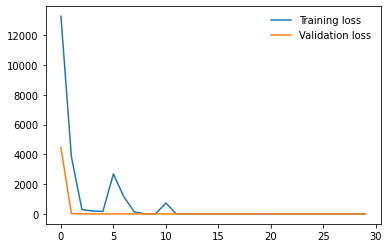

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

In [ ]:
model.load_state_dict(torch.load('CW_MLP_model.pt'))

FileNotFoundError: ignored

In [ ]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data, target in test_loader:
    output = model(data)

    loss = criterion(output, target)

    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)

    correct = np.squeeze(pred.eq(target.data.view_as(pred)))

    for i in range(5):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

#CNN

In [ ]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 4 * 4, 500)

        self.fc2 = nn.Linear(500, number_classes) 

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

model = Net()
print(model)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=lr1)

In [ ]:

valid_loss_min = np.Inf

train_losses, val_losses = [], []

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:

        optimizer.zero_grad()

        output = model(data)

        loss = criterion(output, target)

        loss.backward()

        optimizer.step()

        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in val_loader:

        output = model(data)

        loss = criterion(output, target)

        valid_loss += loss.item()*data.size(0)
        
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)

    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    

    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'CW_CNN_model.pt')
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/CW_CNN_model.pt')
        valid_loss_min = valid_loss

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

In [ ]:
model.load_state_dict(torch.load('CW_CNN_model.pt'))

#TL

In [ ]:
import torch.nn as nn
import torchvision.models as models


model = models.resnet18(pretrained=True)


num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, numberOfClasses)

if train_on_gpu:
    model.cuda()

print(model)

In [ ]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=lr1)

In [ ]:
valid_loss_min = np.Inf


train_losses, val_losses = [], []

for epoch in range(n_epochs):

    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() 
    for data, target in train_loader:

        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()

        output = model(data)

        loss = criterion(output, target)

        loss.backward()

        optimizer.step()

        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in val_loader:

        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        output = model(data)

        loss = criterion(output, target)

        valid_loss += loss.item()*data.size(0)
        
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)

    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'CW_resnet18_model_fine_tune_aug.pt')
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/CW_resnet18_model_fine_tune_aug.pt')
        valid_loss_min = valid_loss

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

In [ ]:
model.load_state_dict(torch.load('CW_resnet18_model_fine_tune_aug.pt'))

In [ ]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data, target in test_loader:

    if train_on_gpu:
        data, target = data.cuda(), target.cuda()

    output = model(data)

    loss = criterion(output, target)

    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)

    correct = np.squeeze(pred.eq(target.data.view_as(pred)))

    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (class_total[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))